In [76]:
# Import Libraries #
import findspark
findspark.init()
from pyspark.sql.functions import split, col, array_contains, translate, round, size, when, udf, lit, mean, count, format_number, collect_list
from pyspark.sql.types import TimestampType, MapType, IntegerType, StringType, ArrayType, FloatType, StructField, StructType
from pyspark.sql import SparkSession
from helper import *

In [77]:
spark = SparkSession.builder.appName('test').master("yarn") \
.config("spark.executor.instances", 9) \
.config("spark.executor.memory", "1G")  \
.getOrCreate()

In [78]:
## MUTE OUTPUT FROM SPARK
logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.OFF)
logger.LogManager.getLogger("akka").setLevel(logger.Level.OFF)
spark.conf.set("spark.driver.log.level", "OFF")

In [79]:
spark

In [80]:
#Event, White, Black, Result, WhiteElo, BlackElo, Opening, TimeControl, Termination, Moves,Eval, UTCTimestamp
schema = StructType([ \
    StructField("Event",StringType(),True), \
    StructField("White",StringType(),True), \
    StructField("Black",StringType(),True), \
    StructField("Result", StringType(), True), \
    StructField("WhiteElo", IntegerType(), True), \
    StructField("BlackElo", IntegerType(), True), \
    StructField("Opening",StringType(),True), \
    StructField("TimeControl",StringType(),True), \
    StructField("Termination",StringType(),True), \
    StructField("Moves", StringType(), True), \
    StructField("Eval", StringType(), True), \
    StructField("UTCTimestamp", TimestampType(), True) \
  ])
df = spark.read.csv("hdfs://namenode:9000/chess_2016_dataset/output/part*", schema=schema)

##### Check Shape of Data

In [81]:
print("shape: ", (df.count(), len(df.columns)))

shape:  (311333, 12)


##### Convert columns to appropriate types

In [82]:
df = convert_types(df)
df.dtypes

[('Event', 'string'),
 ('White', 'string'),
 ('Black', 'string'),
 ('Result', 'string'),
 ('WhiteElo', 'int'),
 ('BlackElo', 'int'),
 ('Opening', 'string'),
 ('TimeControl', 'string'),
 ('Termination', 'string'),
 ('Moves', 'array<string>'),
 ('Eval', 'array<float>'),
 ('UTCTimestamp', 'timestamp')]

In [83]:
eval_difference = 3.0
eval_games = df.where(col("Eval")[0].isNotNull())
eval_games = eval_games.withColumn("WhiteBlunders", (find_white_blunders(col("Eval"), lit(eval_difference))))
eval_games = eval_games.withColumn("BlackBlunders", (find_black_blunders(col("Eval"), lit(eval_difference))))
eval_games.select("TimeControl", "White", "WhiteElo", "WhiteBlunders", "Black", "BlackElo", "BlackBlunders", "Result", "Termination") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()).limit(10).toPandas().head(10)

,TimeControl,White,WhiteElo,WhiteBlunders,Black,BlackElo,BlackBlunders,Result,Termination
0,30+0,broskall,2290,16,BitChess,2401,17,1-0,Time forfeit
1,300+5,faroukii,1914,13,iridion16,1823,11,1/2-1/2,Normal
2,300+4,peterchristofferholm,1500,12,minime,1526,5,0-1,Normal
3,1200+0,Cunchidos,1887,11,sharkawy,1744,11,0-1,Normal
4,360+7,jherickxxx,1576,11,x86,1135,9,1/2-1/2,Normal
5,60+0,fuseew,1569,11,gfvgfv,1595,9,0-1,Time forfeit
6,600+0,carvalho-rac,1696,11,Gr8BanterM8,1634,8,0-1,Time forfeit
7,180+0,MK105,1243,11,nurbek1993,1269,8,1-0,Normal
8,60+2,dpikos,1334,11,aljedrez,1405,7,1/2-1/2,Normal
9,900+0,GeraM5,1489,11,Milos98,1521,7,1-0,Normal


##### Plot Most Blundered Game

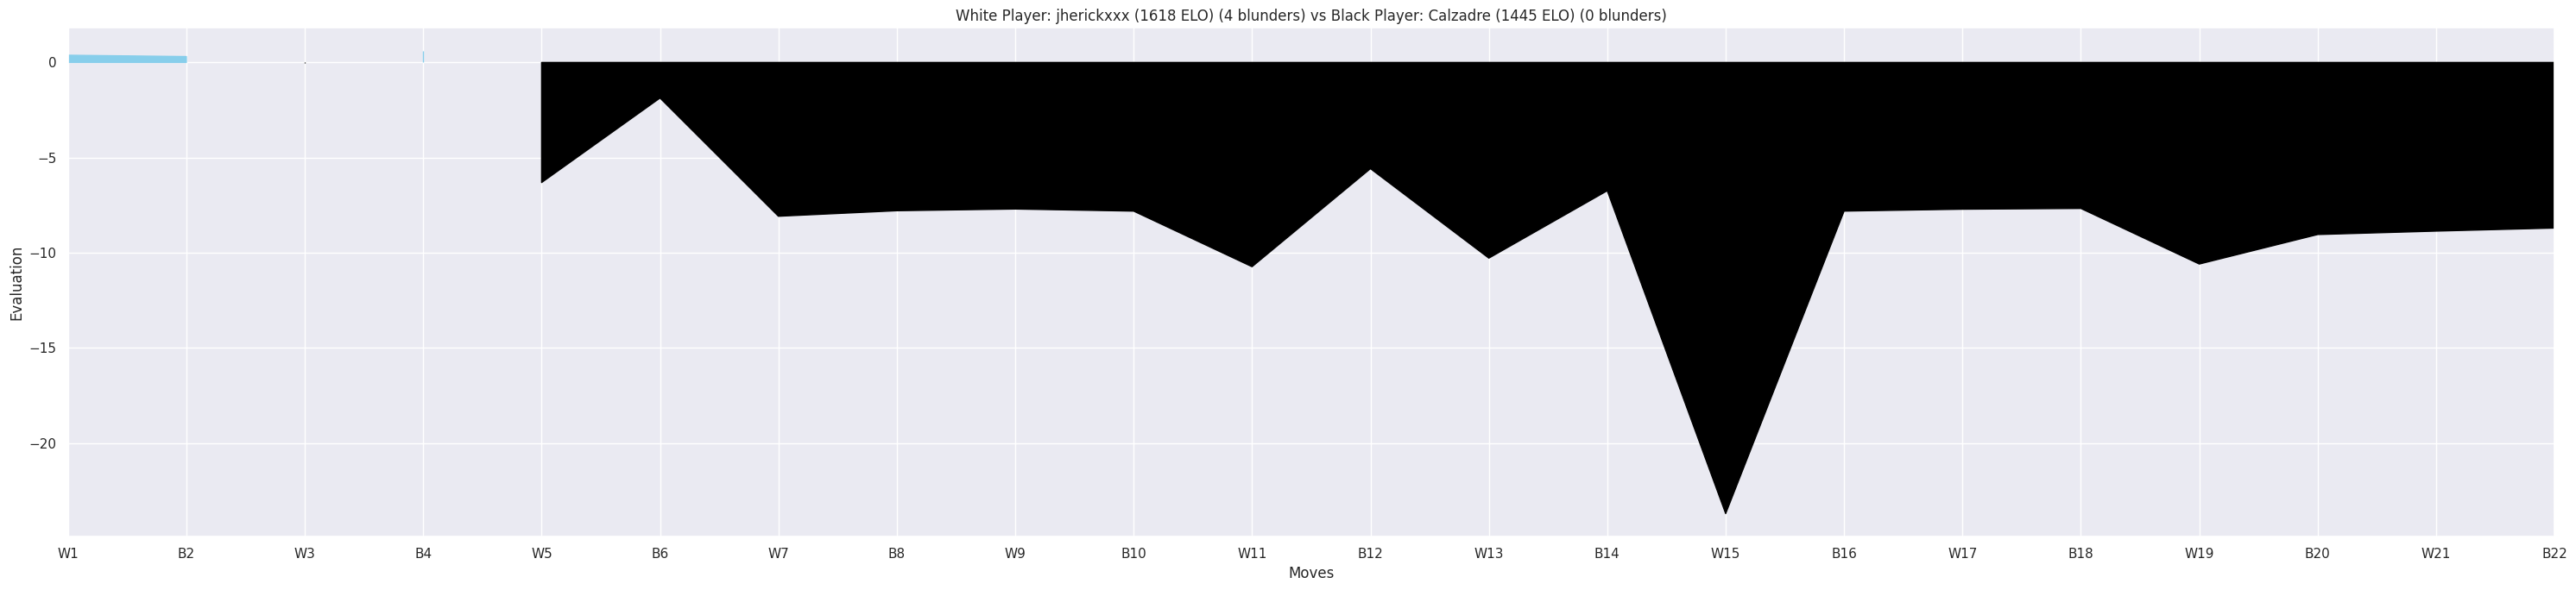

In [84]:
plot_eval_game(eval_games)

### Group By
- Time control ~ (60, 120, 180, 600) etc...
- Elo-Brackets ~ ([1200, 1400], [1500, 1700], [2000-2200]) etc...

#### Time Control Grouping

In [85]:
time_control_white_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("WhiteBlunders"), count("TimeControl")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

time_control_black_blunders_averages = eval_games \
    .groupBy("TimeControl") \
    .agg(mean("BlackBlunders"), count("TimeControl")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))


In [86]:
time_control_white_blunders_averages \
    .orderBy(col("avg(WhiteBlunders)").desc()) \
    .where(col("count(TimeControl)")>1000) \
    .limit(10) \
    .toPandas() \
    .head()

,TimeControl,avg(WhiteBlunders),count(TimeControl)
0,30+0,1.8,1810
1,60+0,1.6,9059
2,900+0,1.5,1056
3,180+0,1.4,3707
4,600+0,1.4,2932


In [87]:
time_control_black_blunders_averages \
    .orderBy(col("avg(BlackBlunders)").desc()) \
    .where(col("count(TimeControl)")>1000) \
    .limit(10) \
    .toPandas() \
    .head()

,TimeControl,avg(BlackBlunders),count(TimeControl)
0,30+0,1.8,1810
1,60+0,1.6,9059
2,120+0,1.5,1097
3,900+0,1.5,1056
4,600+0,1.5,2932


#### Elo Brackets Grouping

Start off by Creating a new spark daraframe column called "EloBracket" which we will later use to group and aggregrate by. When grouping the players by elo brackets we want to use a range that makes sense such that there are not 1 bracket that contains 80% of the playerbase and ones that only contain a small fraction. E.g We want evenly distributed amount of players in each bracket (as far as that is possible).

/tmp/ipykernel_358874/1011671360.py:5: UserWarning:                             

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(elo_list, kde=True, color ='green', bins=20)


<Axes: ylabel='Density'>

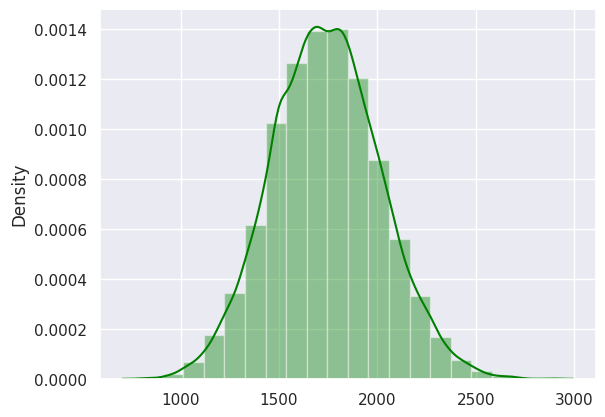

In [88]:
# Start by getting all the elo column values in the dataframe.
elo_list = eval_games.select(collect_list("WhiteElo")).first()[0]
sns.set_theme(style="ticks")
sns.set_style('darkgrid')
sns.distplot(elo_list, kde=True, color ='green', bins=20)

"EloBracket" column should be of type String and contain values in format: "0-1200", "1200-1600", "1600-2000", "2000-3000"

In [89]:
eval_games = eval_games.withColumn("EloBracket", \
                         when((0 < eval_games.WhiteElo) & (eval_games.WhiteElo < 1500), lit("<1500")) \
                        .when((1500 <= eval_games.WhiteElo) & (eval_games.WhiteElo <= 1750), lit("1500-1750")) \
                        .when((1750 < eval_games.WhiteElo) & (eval_games.WhiteElo <= 2000), lit("1751-2000")) \
                        .otherwise(lit(">2000")))

In [90]:
eval_games.show()

+--------------------+----------------+----------------+------+--------+--------+--------------------+-----------+------------+--------------------+--------------------+-------------------+-------------+-------------+----------+
|               Event|           White|           Black|Result|WhiteElo|BlackElo|             Opening|TimeControl| Termination|               Moves|                Eval|       UTCTimestamp|WhiteBlunders|BlackBlunders|EloBracket|
+--------------------+----------------+----------------+------+--------+--------+--------------------+-----------+------------+--------------------+--------------------+-------------------+-------------+-------------+----------+
|Rated Blitz tourn...|        carlborz|    fernandocoto|   1-0|    2199|    2379|English Opening: ...|      180+0|      Normal|['c4',  'c6',  'g...|[0.03, 0.33, -0.1...|2016-05-14 03:32:00|            0|            3|     >2000|
|Rated Bullet tour...|AnatolyPetrosian|jorgitoelgigante|   1-0|    2247|    1902|Tar

In [91]:
elo_bracket_white_blunders_averages = eval_games \
    .groupBy("EloBracket") \
    .agg(mean("WhiteBlunders"), count("EloBracket")) \
    .withColumn("avg(WhiteBlunders)", format_number("avg(WhiteBlunders)", 1))

elo_bracket_black_blunders_averages = eval_games \
    .groupBy("EloBracket") \
    .agg(mean("BlackBlunders"), count("EloBracket")) \
    .withColumn("avg(BlackBlunders)", format_number("avg(BlackBlunders)", 1))

In [92]:
elo_bracket_white_blunders_averages.orderBy(col("avg(WhiteBlunders)").desc()).limit(10).toPandas().head()

,EloBracket,avg(WhiteBlunders),count(EloBracket)
0,<1500,1.9,7535
1,1500-1750,1.5,13183
2,1751-2000,1.4,12354
3,>2000,1.1,6815


In [93]:
elo_bracket_black_blunders_averages.orderBy(col("avg(BlackBlunders)").desc()).limit(10).toPandas().head()

,EloBracket,avg(BlackBlunders),count(EloBracket)
0,<1500,1.7,7535
1,1500-1750,1.6,13183
2,1751-2000,1.5,12354
3,>2000,1.4,6815


In [94]:
a = eval_games.select("Moves") \
    .orderBy(col("WhiteBlunders").desc(), col("BlackBlunders").desc()) \
    .limit(1) \
    .take(1)[0][0]
print([x.replace("'","").replace('"', "").strip("'") for x in a])

['g3', ' c6', ' Bg2', ' d5', ' e3', ' Nf6', ' Ne2', ' Bg4', ' O-O', ' Bxe2', ' Qxe2', ' e6', ' d3', ' Nbd7', ' Bd2', ' Be7', ' b3', ' c5', ' Bc1', ' c4', ' bxc4', ' dxc4', ' dxc4', ' O-O', ' c3', ' Rc8', ' Nd2', ' Rb8', ' Ne4', ' b6', ' Nxf6+', ' Nxf6', ' Bd2', ' Bc5', ' Be1', ' Qe8', ' f4', ' Qe7', ' Bf2', ' Nd7', ' Rfe1', ' Nf6', ' Qf1', ' Rfd8', ' Rad1', ' Ba3', ' Rd2', ' Bc5', ' Rde2', ' Re8', ' e4', ' Rf8', ' Bxc5', ' Qxc5+', ' Kh1', ' Qxc4', ' e5', ' Qc5', ' g4', ' Nd5', ' g5', ' Nxf4', ' Qxf4', ' Rbc8', ' g6', ' hxg6', ' Bf3', ' Qxc3', ' Rg1', ' Rc4', ' Qg3', ' Qd4', ' Reg2', ' Qh4', ' Qxh4', ' Rxh4', ' Rg3', ' Rd4', ' R3g2', ' Rdd8', ' Bg4', ' f6', ' Bf3', ' Kf7', ' Bg4', ' Ke7', ' Bf3', ' f5', ' Bh5', ' g5', ' Rxg5', ' g6', ' Rxg6', ' Kd7', ' Rg7+', ' Kc6', ' R7g6', ' Kc5', ' R6g5', ' Kb4', ' Bg6', ' b5', ' Bxf5', ' Ka5', ' Bxe6', ' Rfe8', ' Bf5', ' Rxe5', ' Rg6', ' Rde8', ' Rg7', ' Kb6', ' R7g6+', ' Kc5', ' R6g5', ' Kd4', ' R5g4+', ' Ke3', ' Rg5', ' Kd4', ' R5g4+', ' Kc5', ' 

## BIG HEAVY FOOKIN WORK

### Move List to FEN notation
ta den lista me moves som input, lag en FEN string.


In [95]:
rows = eval_games.select("Moves").take(1)
moves = rows[0].Moves
moves

["'c4'",
 " 'c6'",
 " 'g3'",
 " 'd5'",
 " 'Bg2'",
 " 'Nf6'",
 " 'Nf3'",
 " 'Bf5'",
 " 'O-O'",
 " 'e6'",
 " 'b3'",
 " 'Be7'",
 " 'Bb2'",
 " 'O-O'",
 " 'd3'",
 " 'h6'",
 " 'Nbd2'",
 " 'Nbd7'",
 " 'Qc2'",
 " 'Rc8'",
 " 'e4'",
 " 'dxe4'",
 " 'dxe4'",
 " 'Bh7'",
 " 'Rad1'",
 " 'Qc7'",
 " 'Nd4'",
 " 'Rfd8'",
 " 'f4'",
 " 'a6'",
 " 'h3'",
 " 'c5'",
 " 'Ne2'",
 " 'Nb8'",
 " 'f5'",
 " 'exf5'",
 " 'exf5'",
 " 'Nc6'",
 " 'Ne4'",
 " 'Nd4'",
 " 'Nxd4'",
 " 'cxd4'",
 " 'g4'",
 " 'Nxe4'",
 " 'Qxe4'",
 " 'Bc5'",
 " 'Kh1'",
 " 'b6'",
 " 'Bxd4'",
 " 'Re8'",
 " 'Qf3'",
 " 'Kh8'",
 " 'Bxc5'",
 " 'bxc5'",
 " 'Rd5'",
 " 'Bg8'",
 " 'f6'",
 " 'g5'",
 " 'Qd3'",
 " 'Bh7'",
 " 'Qd2'",
 " 'Qg3'",
 " 'Rd7'",
 " 'Rf8'",
 " 'Qf2'",
 " 'Qxf2'",
 " 'Rxf2'",
 " 'Rcd8'",
 " 'Rfd2'",
 " 'Rde8'",
 " 'Re7'",
 " 'Bg6'",
 " 'Rdd7'",
 " 'Kg8'",
 " 'Ra7'",
 " 'Ra8'",
 " 'Rxa8'",
 " 'Rxa8'",
 " 'Bxa8'",
 " 'Bd3'",
 " 'Bd5'",
 " 'Kh7'",
 " 'Rxf7+'",
 " 'Kg6'",
 " 'Rf8'",
 " 'Be4+'"]

### First moves
kan bruk d me elo og result for å se ka som e vanlig for good players

In [96]:
rows = eval_games.select("Result", "WhiteElo", "BlackElo", "Moves").take(100)

first_moves = []
for row in rows: 
    move = row.Moves[:2]
    first_move = [row.Result, row.WhiteElo, row.BlackElo, move]
    first_moves.append(first_move)

first_moves

[['1-0', 2199, 2379, ["'c4'", " 'c6'"]],
 ['1-0', 2247, 1902, ["'d4'", " 'd5'"]],
 ['1-0', 1824, 1618, ["'d4'", " 'd6'"]],
 ['1-0', 1632, 1559, ["'e4'", " 'e5'"]],
 ['0-1', 1260, 1336, ["'e3'", " 'g6'"]],
 ['1-0', 1846, 1948, ["'e4'", " 'Nf6'"]],
 ['0-1', 1627, 1364, ["'c4'", " 'Nf6'"]],
 ['1-0', 1603, 1583, ["'e4'", " 'e6'"]],
 ['0-1', 1621, 1813, ["'f4'", " 'e6'"]],
 ['0-1', 1685, 1653, ["'d3'", " 'e6'"]],
 ['0-1', 1728, 1555, ["'e4'", " 'e6'"]],
 ['1-0', 1629, 1654, ["'e4'", " 'e5'"]],
 ['1-0', 1779, 1830, ["'d4'", " 'd5'"]],
 ['0-1', 1718, 1746, ["'e3'", " 'e5'"]],
 ['1-0', 2118, 1761, ["'d4'", " 'd5'"]],
 ['0-1', 1993, 2063, ["'e4'", " 'e5'"]],
 ['0-1', 1797, 2044, ["'d4'", " 'd6'"]],
 ['0-1', 1931, 1849, ["'e4'", " 'e5'"]],
 ['0-1', 1765, 1722, ["'e4'", " 'c5'"]],
 ['1-0', 1794, 1477, ["'d4'", " 'd5'"]],
 ['1-0', 2086, 1772, ["'e4'", " 'c5'"]],
 ['1-0', 1299, 1314, ["'e4'", " 'Nf6'"]],
 ['1-0', 1821, 1794, ["'e4'", " 'g6'"]],
 ['0-1', 2350, 2291, ["'d4'", " 'Nf6'"]],
 ['0-1', 193